In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sparkmetrics import SparkMetric, DataLoader, plot_shuffleIO, plot_heapMemory

In [2]:
data_path = Path("/run/media/berombau/data/thesis/notebooks/metrics_5execs")
timezone = 'Europe/Brussels'
dl = DataLoader(data_path, timezone)
df = dl.load_dataset()

df

,executor,metric,time,value
0,1,executor.diskBytesSpilled,2020-11-21 20:58:40+01:00,0
1,1,executor.diskBytesSpilled,2020-11-21 20:58:50+01:00,0
2,1,executor.diskBytesSpilled,2020-11-21 20:59:03+01:00,0
3,1,executor.diskBytesSpilled,2020-11-21 20:59:10+01:00,0
4,1,executor.diskBytesSpilled,2020-11-21 20:59:24+01:00,0
...,...,...,...,...
32287,4,NettyBlockTransfer.shuffle-server.usedDirectMe...,2020-11-21 21:30:56+01:00,67108864
32288,4,NettyBlockTransfer.shuffle-server.usedDirectMe...,2020-11-21 21:31:06+01:00,67108864
32289,4,NettyBlockTransfer.shuffle-server.usedDirectMe...,2020-11-21 21:31:16+01:00,67108864
32290,4,NettyBlockTransfer.shuffle-server.usedDirectMe...,2020-11-21 21:31:26+01:00,67108864


# Plot of single executor memory

## Stages

- 0
    - repartition
    - Tools.scala:94
    - 3s
- 1
    - count
    - BlsSpeller.scala:159
    - 0.5s
    - create input motifIterator
- 2
    - repartition
    - Tools.scala:94
    - skipped
- 3
    - flatMap
    - Tools.scala:122
    - 22min
    - run motifIterator
- 4
    - runJob
    - SparkHadoopWriter.scala:78
    - 2.7min
    - write output

## Stage 3

Closer look at stage 3 for exector 1

- 23:46
    - Start of task 1 in stage 3 by exectutor
    - iratic onheap execution memory behaviour
    - growing memory of motifIterator to max 800MB
- 00:01
    - unknown event
    - motifIterator is done?
    - flatMap of 
- 00:05
    - end of task 1
    - all memory metrics to 0
    - exectur is idle

%matplotlib inlineStart of Stage 3 (pipe to MotifIterator). Stage 3 end at 23:05

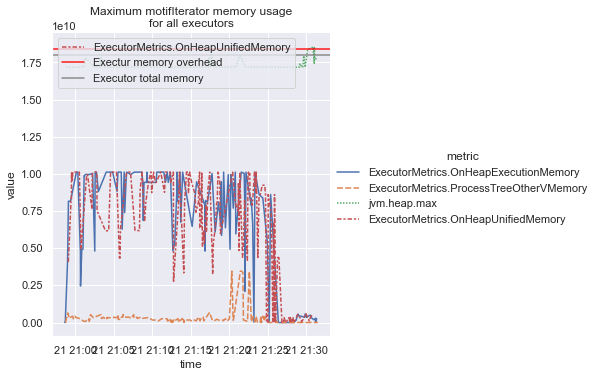

In [18]:
import seaborn as sns
subset_metrics = [
    "ExecutorMetrics.ProcessTreeOtherVMemory",
    "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
    "jvm.heap.max"
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor != 'driver'")
            ).groupby(["metric", "time"]).agg({'value': 'max'}).reset_index()

df_subset = df_subset.sort_values(by="time")
df_subset = df_subset[::5]

g = sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")
plt.title("Maximum motifIterator memory usage\nfor all executors")
for ax in g.axes.ravel():
    ax.axhline(18432e6, alpha=0.9, color='red', label="Exectur memory overhead")
    ax.axhline(18e9, alpha=0.9, color='grey', label="Executor total memory")
    handles, _ = ax.get_legend_handles_labels()
    plt.legend(handles = handles[3:])

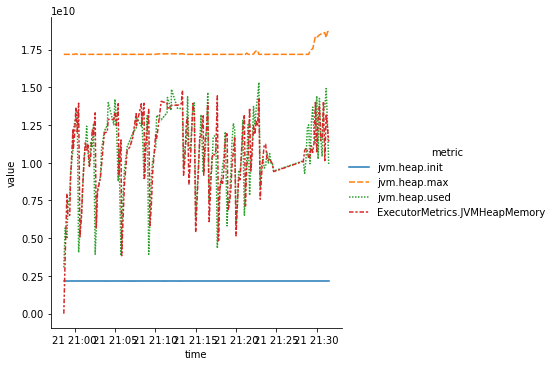

In [24]:
plot_heapMemory(df, executor=1)

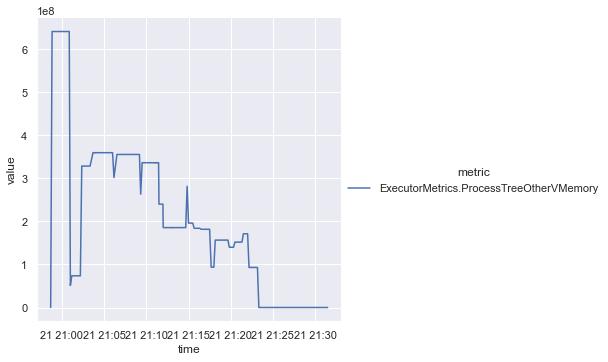

In [16]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
#     "executor.memoryBytesSpilled",
#     "executor.diskBytesSpilled",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

In [17]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
    "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
    "executor.memoryBytesSpilled",
    "executor.diskBytesSpilled",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
            .query("executor == driver"))
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

NameError: name 'df_nd' is not defined

Same erratic OnHeapExecutionMemory behaviour for all execturs.
Ceiling at 2.6GB

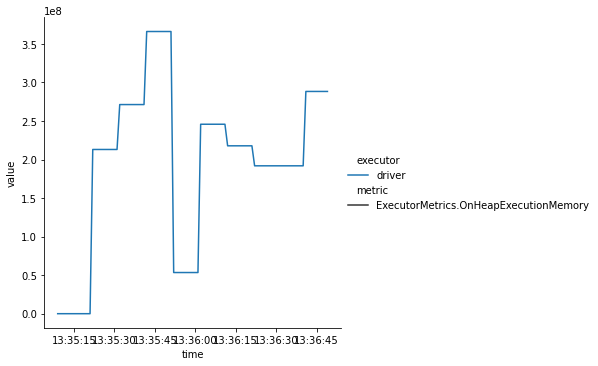

In [29]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="executor", kind="line")

Task 12 at executor 13 has +4 GB of extra memory for motifIterator then the regular 1 GB. Why?
No other metrics are different, except Shuffle Remote Reads of 5.7 MiB instead of <1MiB

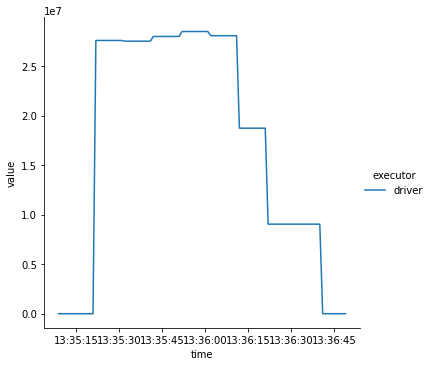

In [30]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemCloserory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="executor", hue="executor", kind="line")

In [31]:
df = pd.DataFrame.from_dict(data)
pd.options.display.max_columns = None
df

NameError: name 'data' is not defined

In [ ]:
df["submissionTime"] = pd.to_datetime(df["submissionTime"], unit="ms")
df["completionTime"] = pd.to_datetime(df["completionTime"], unit="ms")
df["executorCpuTime"] = df["executorCpuTime"] / 1000
df["executorDeserializeCpuTime"] = df["executorDeserializeCpuTime"] / 1000
df

In [ ]:
def plot_n_active_tasks(df):
#     colormap = cm.get_cmap('viridis', df["stageId"].max() + 1)
#     colors = df["jobId"].apply(lambda x: colormap.colors[x])
    plot = df.plot.bar(x="submissionTime", y=["numTasks"])
    
def plot_jvm_cpu_usage(df):
    plot = df.plot.bar(x="submissionTime", y=["executorCpuTime"])

def plot_time_components(df):
    components = [
        "executorDeserializeCpuTime", 
        "executorDeserializeTime",
        "executorCpuTime",
        "shuffleWriteTime",
        "resultSerializationTime",
        "shuffleFetchWaitTime",
        "jvmGCTime",
    ]
#     fig, ax = plt.subplots(1, 1)
    ax = df.plot.line(x="submissionTime", y="executorRunTime", use_index=False)
    df.plot.bar(x="submissionTime", y=components, stacked=True, use_index=False, ax=ax)
    
    
def plot_peak_memory(df):
    plot = df.plot.bar(x="submissionTime", y=["peakExecutionMemory"])

In [ ]:
plot_n_active_tasks(df)
plot_jvm_cpu_usage(df)
plot_time_components(df)
plot_peak_memory(df)